In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Indrop K562

In [3]:
figprefix = 'figures/Klein_K562_cells'
datadir = '/home/mffang/data/counts/Klein_2015/K562/'

## Load Klein data

In [4]:
Klein = pd.read_csv('data/Klein/GSM1599500_K562_cells.csv')
Klein_genes = np.array(Klein.to_numpy().T[0,],dtype=str)
Klein

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.229,0.230,0.231,0.232,0.233,0.234,0.235,0.236,0.237,0.238
0,A1BG,0,0,0,0,1,0,0,3,0,...,2,0,0,0,0,1,0,1,0,0
1,A1BG-AS1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A1CF,0,0,0,1,0,0,1,0,2,...,1,0,0,0,0,0,1,0,3,1
3,A2M,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A2M-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25430,ZYG11A,2,1,1,0,3,0,1,0,1,...,0,0,2,0,0,0,1,1,3,0
25431,ZYG11B,3,2,1,6,3,2,8,1,2,...,0,0,2,1,1,3,4,1,2,2
25432,ZYX,0,0,0,0,5,1,1,0,1,...,0,0,2,0,2,0,1,1,0,4
25433,ZZEF1,3,0,1,2,2,0,1,0,0,...,1,0,0,1,1,0,2,0,0,0


In [5]:
Klein_genes[Klein.sum(1)>250000],Klein.sum(1).max()

TypeError: can only concatenate str (not "int") to str

In [ ]:
'ERCC-00131' in Klein_genes

## Load kb data

In [22]:
K562 = ad.read(datadir + 'counts_unfiltered/adata.h5ad')
K562

AnnData object with n_obs × n_vars = 113645 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

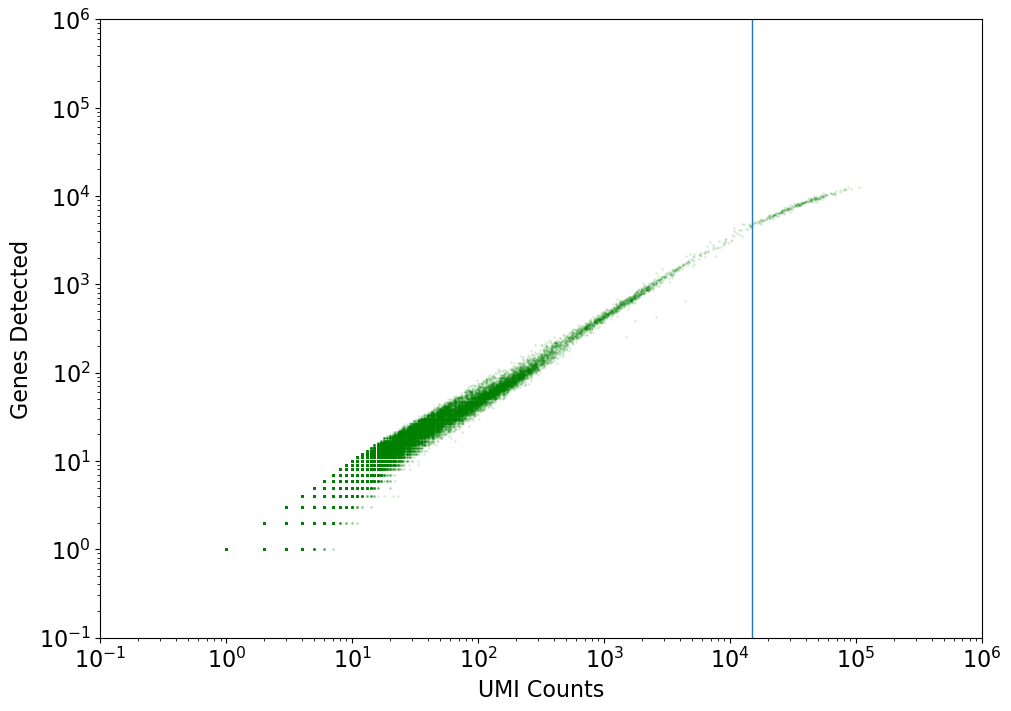

In [23]:
rna = K562.copy()
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,1000000))
ax.set_ylim((0.1,1000000))
ax.axvline(x=15000,linewidth=1)

plt.show()

In [24]:
K562 = K562[mtx.sum(axis=1)>15000]
K562

View of AnnData object with n_obs × n_vars = 216 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

## Check agreement

In [12]:
import pandas as pd

# Read CSV file
df = pd.read_csv('data/biomart_export.csv')
df['Gene name'] = df['Gene name'].str.upper()

# Display the first few rows of the dataframe
print(df.head())

# Create dictionary mapping Gene name to Gene stable ID
gene2id = df.set_index('Gene name')['Gene stable ID'].to_dict()
id2gene = df.set_index('Gene stable ID')['Gene name'].to_dict()

    Gene stable ID Gene name  \
0  ENSG00000210049     MT-TF   
1  ENSG00000211459   MT-RNR1   
2  ENSG00000210077     MT-TV   
3  ENSG00000210082   MT-RNR2   
4  ENSG00000209082    MT-TL1   

                                    Gene description  
0  mitochondrially encoded tRNA-Phe (UUU/C) [Sour...  
1  mitochondrially encoded 12S rRNA [Source:HGNC ...  
2  mitochondrially encoded tRNA-Val (GUN) [Source...  
3  mitochondrially encoded 16S rRNA [Source:HGNC ...  
4  mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...  


In [7]:
ensg_ids = []
idx = []
# Example usage
for i,g in enumerate(Klein_genes):
    gene = g.upper()
    if gene in gene2id:
        ensg_id = gene2id[gene]
        ensg_ids.append(ensg_id)
        idx.append(i)
len(ensg_ids)

22036

In [8]:
compare = K562.copy()
genes = [gene.split('.')[0] for gene in compare.var_names]
compare.var_names = np.array(genes, dtype=str)
compare.var

NameError: name 'K562' is not defined

In [13]:
compare = compare[:,compare.var_names.isin(ensg_ids)]

In [14]:
compare.var['gene name'] = [id2gene[id] for id in list(compare.var_names)]

/tmp/ipykernel_1217652/1143993761.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  compare.var['gene name'] = [id2gene[id] for id in list(compare.var_names)]


In [15]:
kgenes = np.array([g.upper() for g in Klein_genes])

In [16]:
pure_gene_idx = [np.where(kgenes == g)[0][0] for g in compare.var['gene name'].tolist()]

In [17]:
klein_x = np.array(Klein.to_numpy().T[1:,],dtype=int)
klein_x

array([[0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 1, ..., 4, 0, 0]])

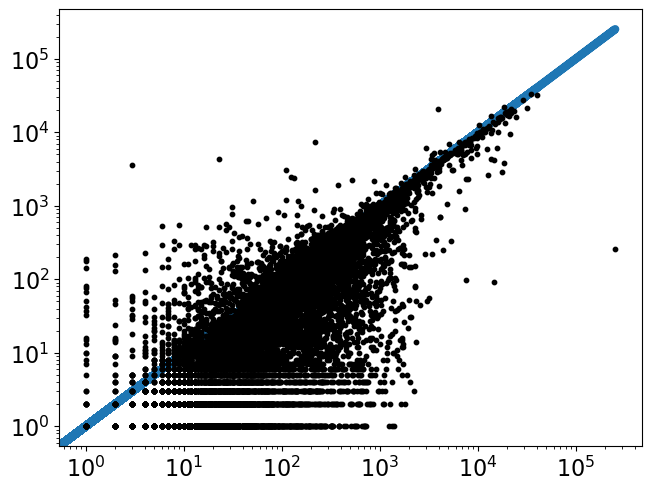

In [18]:
compare.X = compare.layers['ambiguous'].toarray()+compare.layers['mature'] .toarray()
plt.scatter(klein_x.sum(0)[np.array(pure_gene_idx)],compare.X.sum(0),s=10,c='k')
plt.loglog(klein_x.sum(0)[np.array(pure_gene_idx)],klein_x.sum(0)[np.array(pure_gene_idx)],zorder=0)

## Check if RNA solution and cell gene expression matches

In [26]:
pure = ad.read('/home/mffang/data/counts/Klein_2015/pure/counts_unfiltered/adata.h5ad')
rna = pure.copy()
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 
pure = rna[np.asarray(mtx.sum(axis=1))>15000]
pure

View of AnnData object with n_obs × n_vars = 916 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

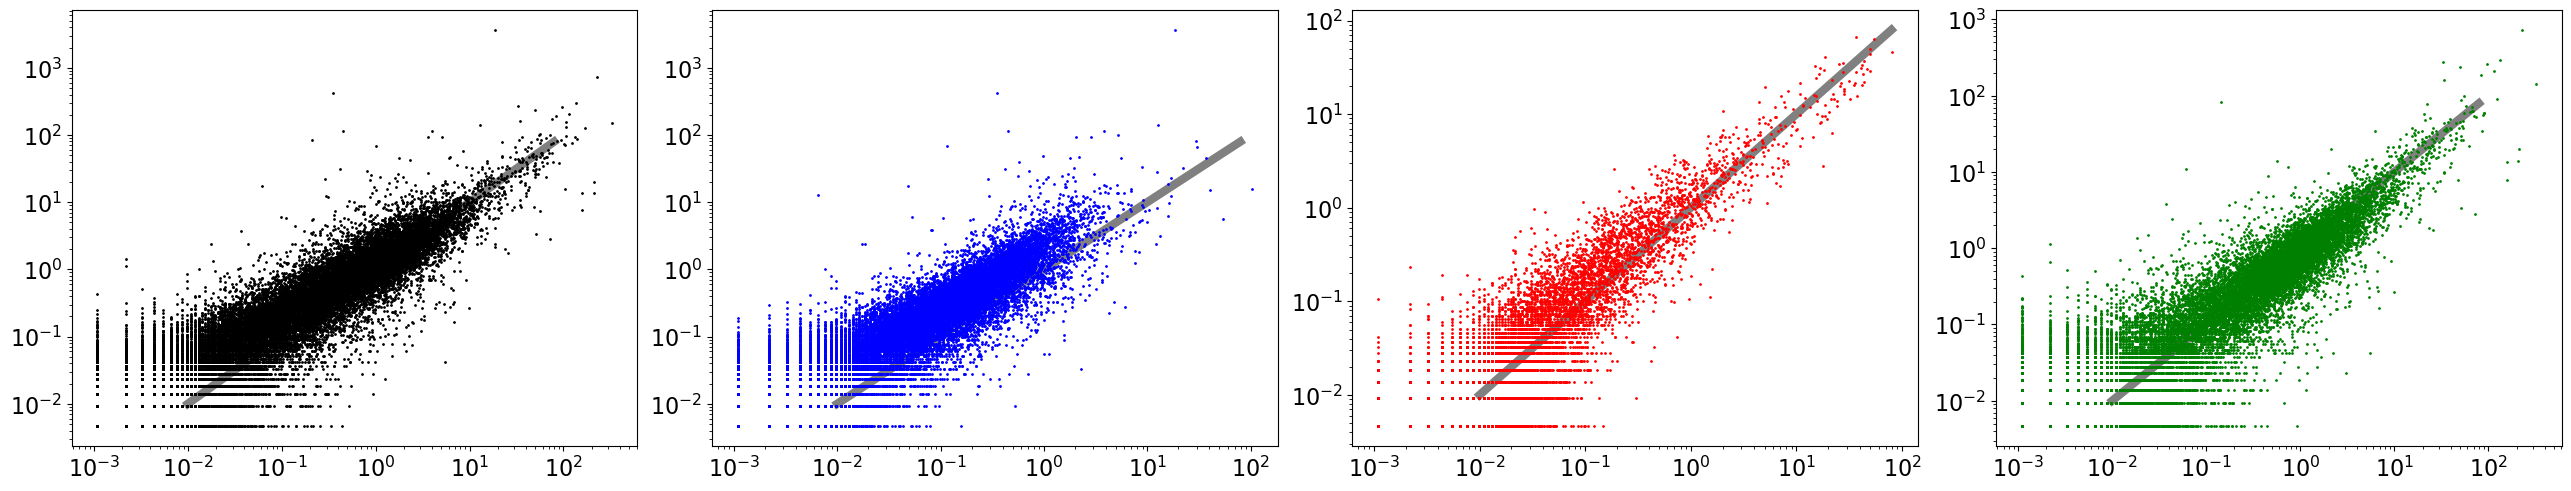

In [45]:
x = 10**np.arange(-2,2,0.1)
pure.X = pure.layers['ambiguous']+pure.layers['mature']+pure.layers['nascent']
K562.X = K562.layers['ambiguous']+K562.layers['mature']+K562.layers['nascent'] 

fig, axs = plt.subplots(1,4,figsize=(25.6,4.8))

axs[0].scatter(pure.X.toarray().mean(0),K562.X.toarray().mean(0),s=1,color='k')
axs[1].scatter(pure.layers['nascent'].toarray().mean(0),K562.layers['nascent'].toarray().mean(0),s=1,color='blue')
axs[2].scatter(pure.layers['mature'].toarray().mean(0),K562.layers['mature'].toarray().mean(0),color='r',s=1)
axs[3].scatter(pure.layers['ambiguous'].toarray().mean(0),K562.layers['ambiguous'].toarray().mean(0),color='g',s=1)

axs[0].plot(x,x,zorder=0,color='gray')
axs[1].plot(x,x,zorder=0,color='gray')
axs[2].plot(x,x,zorder=0,color='gray')
axs[3].plot(x,x,zorder=0,color='gray')

for i in range(len(axs)):
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

## Normalized covariance

In [17]:
adata = K562.copy()
adata.X = adata.layers['nascent'] + adata.layers['mature'] + adata.layers['ambiguous']
ERCC = adata[:,-92:]
adata = adata[:,:-92]
adata

View of AnnData object with n_obs × n_vars = 238 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [11]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

/tmp/ipykernel_461745/1221925009.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_id'] = adata.var_names


,gene_id
ENSG00000228037,ENSG00000228037.1
ENSG00000142611,ENSG00000142611.17
ENSG00000284616,ENSG00000284616.1
ENSG00000157911,ENSG00000157911.11
ENSG00000260972,ENSG00000260972.1
...,...
ENSG00000275063,ENSG00000275063.1
ENSG00000277856,ENSG00000277856.1
ENSG00000271254,ENSG00000271254.7
ENSG00000268674,ENSG00000268674.2


0.40091145 0.083182335 0.45171362


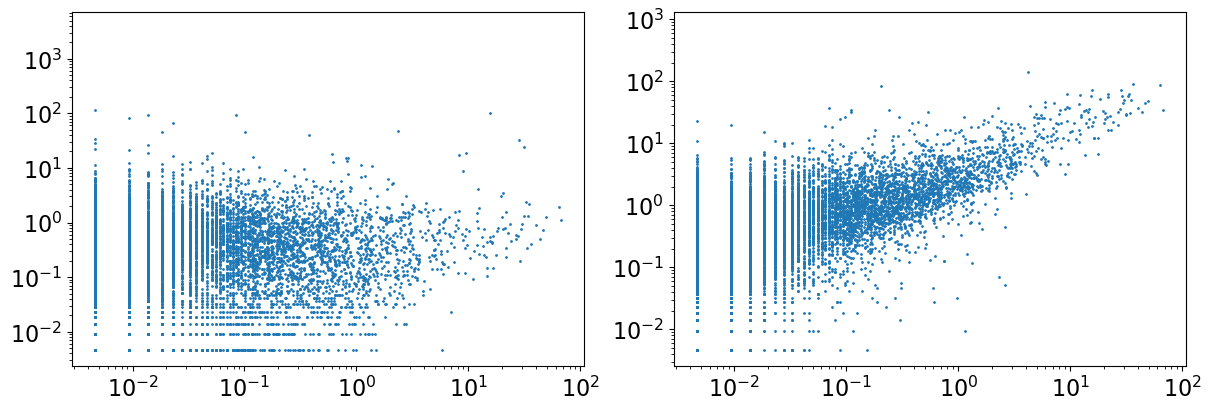

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

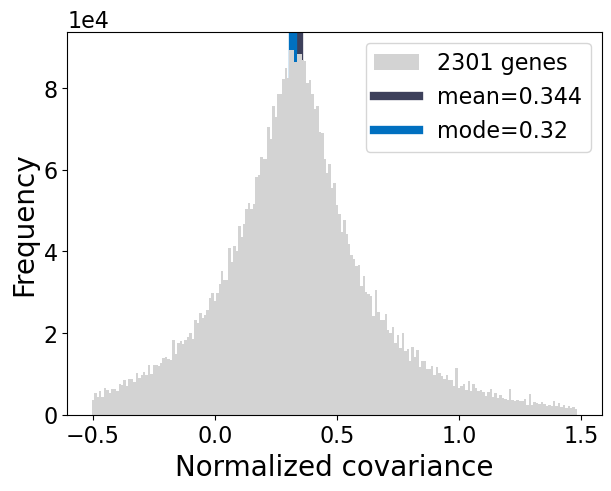

In [18]:
fig,axs = plt.subplots(1,1,figsize=(6,4.8))
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

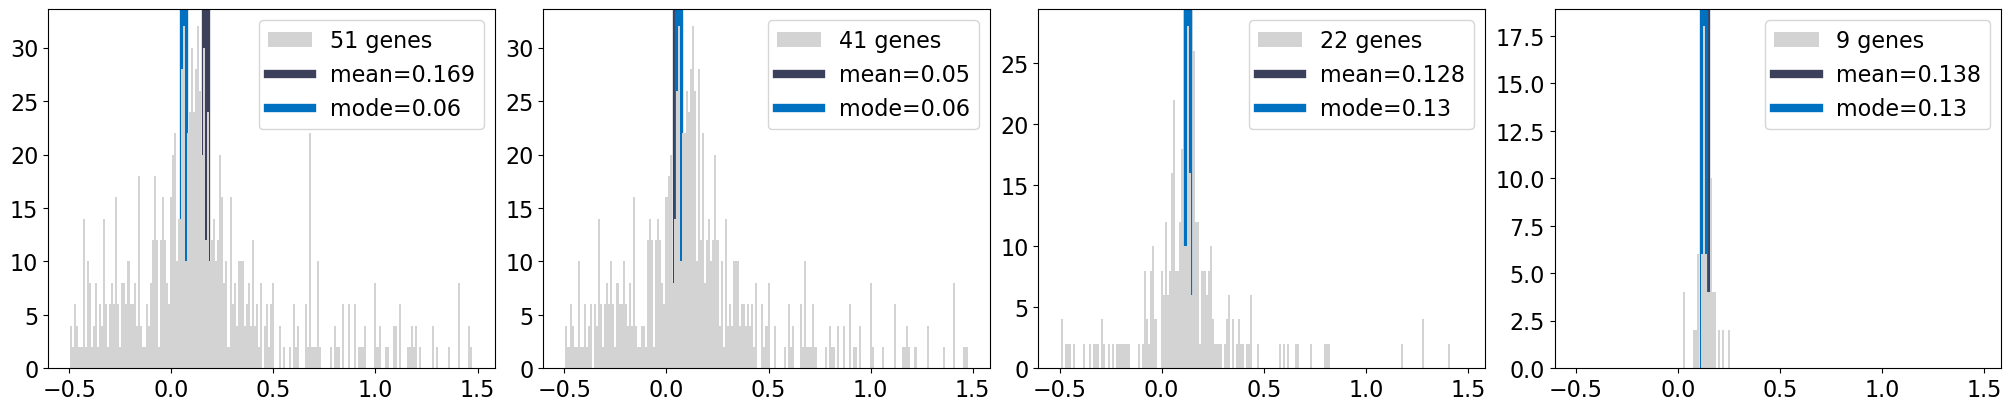

In [12]:
fig,axs = plt.subplots(1,4,figsize=(20,4))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[1],min_mean=0.01)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[2],min_mean=0.1)
s = estimate_s(N1=ERCC.X.toarray(),ax=axs[3],min_mean=1)

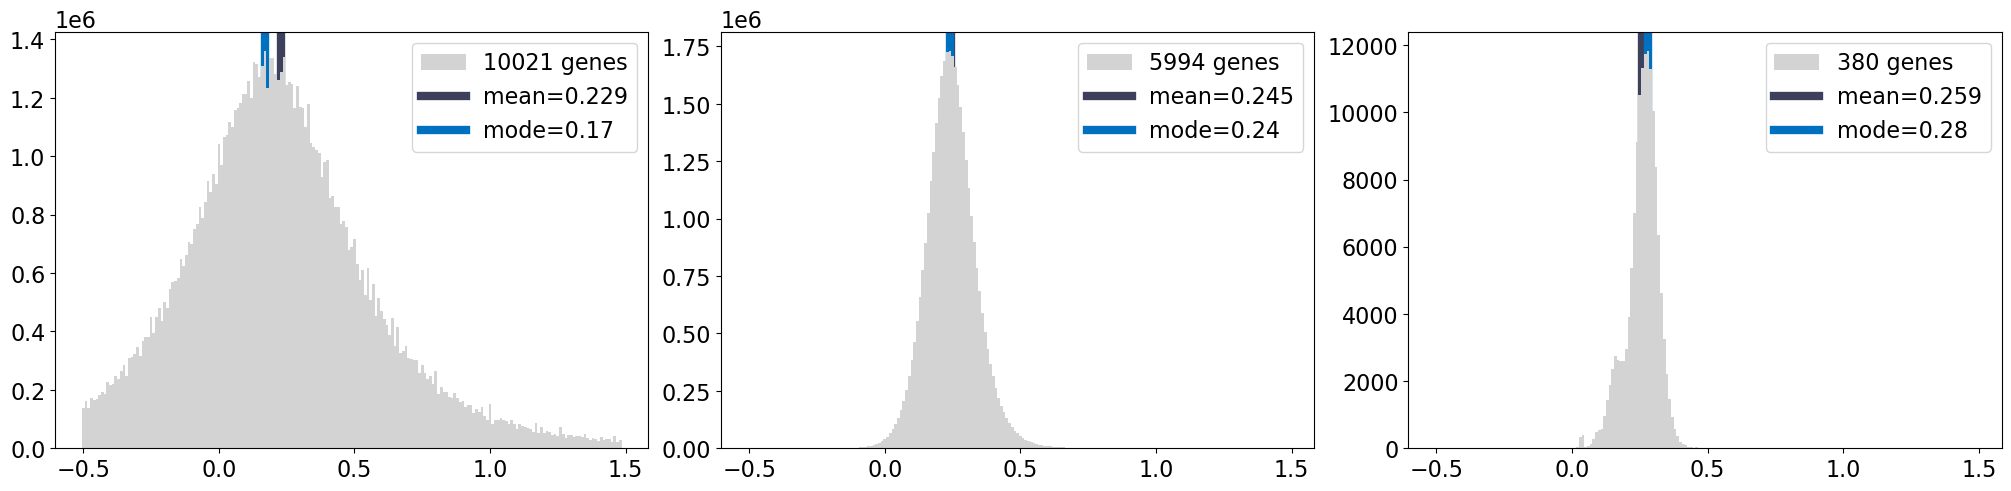

In [20]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.X.toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.X.toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.X.toarray(),ax=axs[2],min_mean=10)

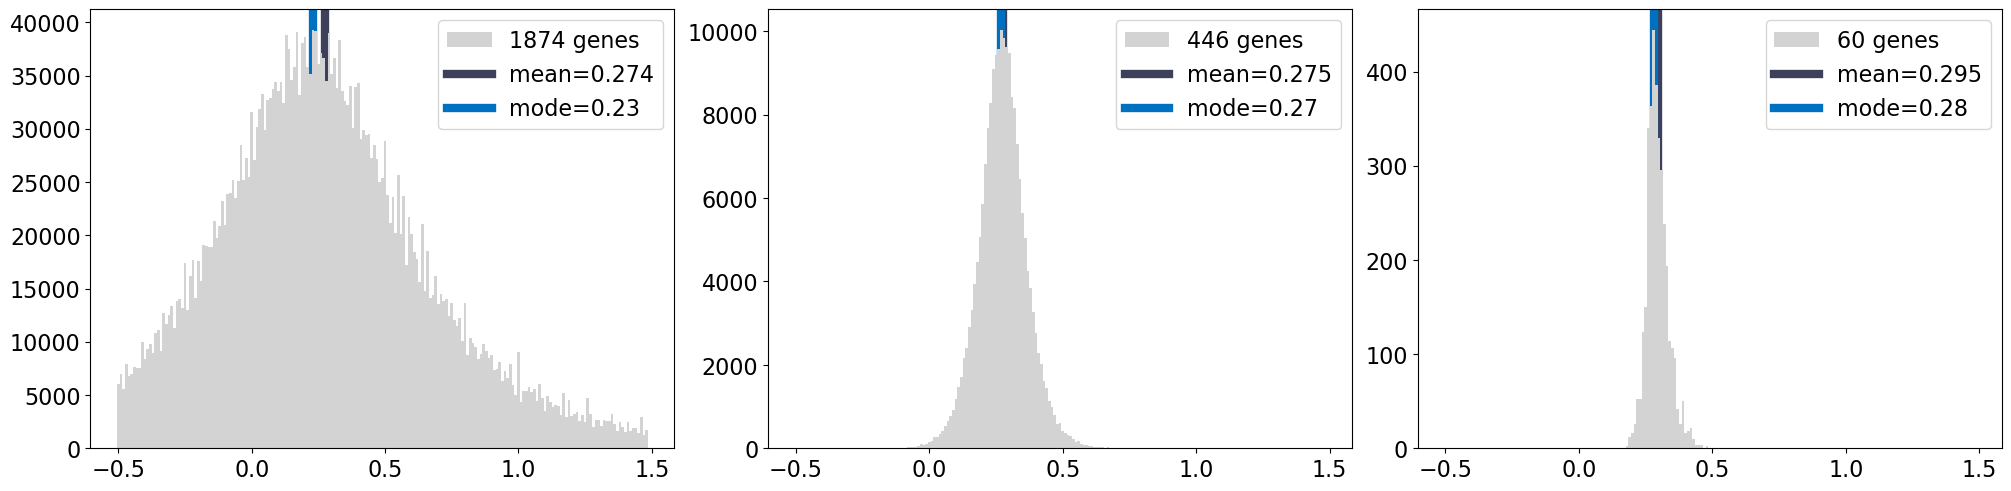

In [21]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10)

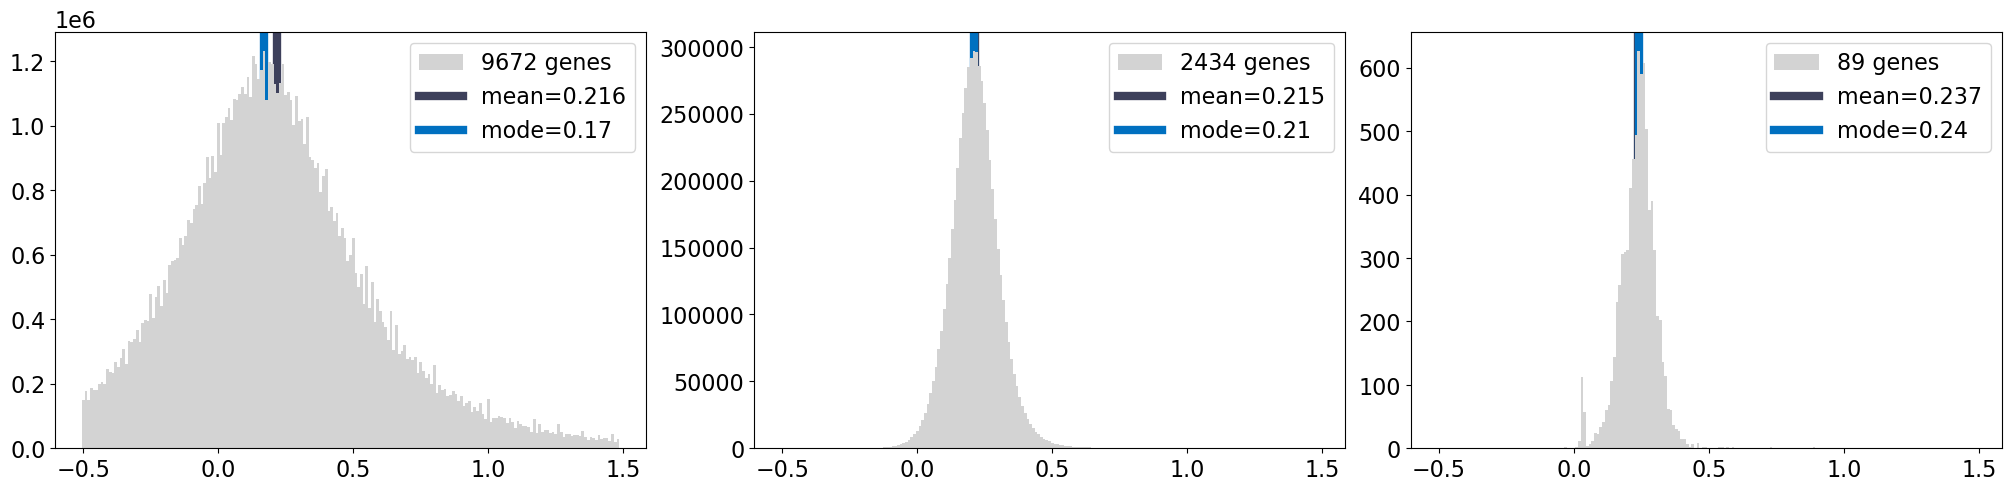

In [22]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=10)

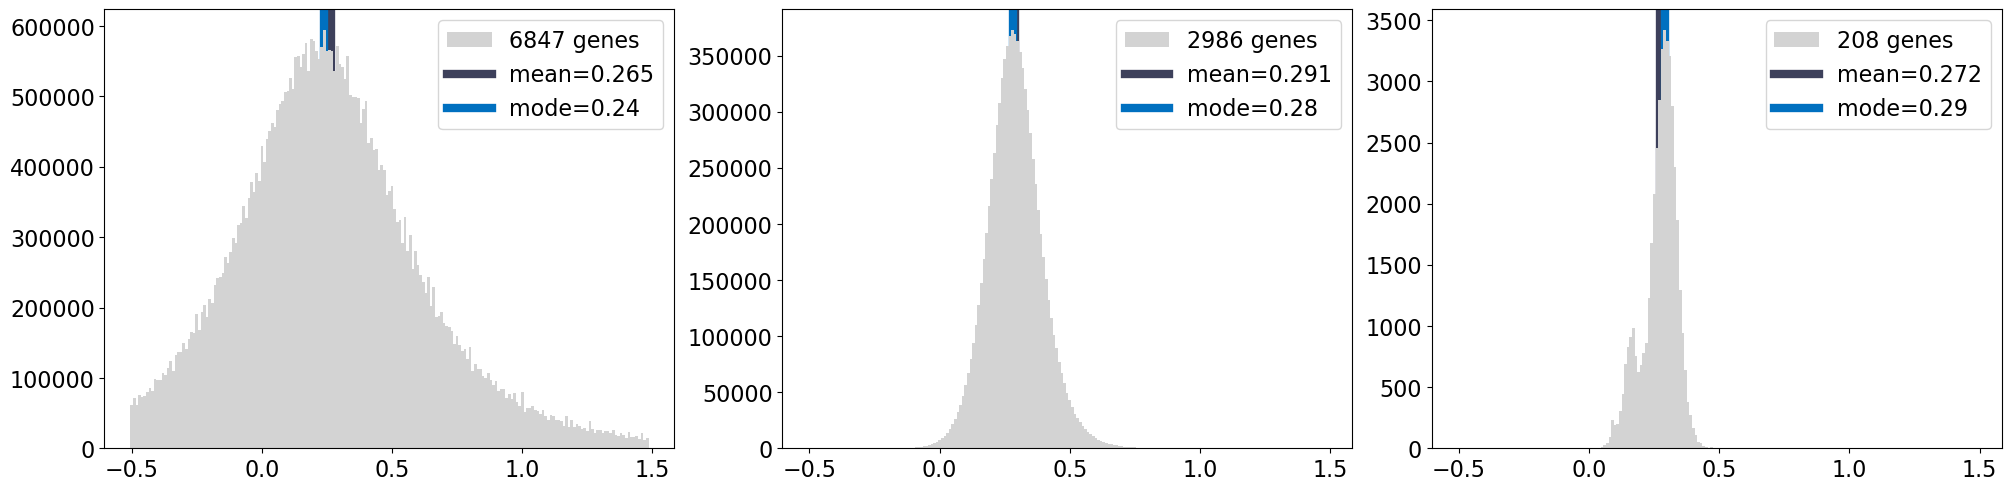

In [23]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf)

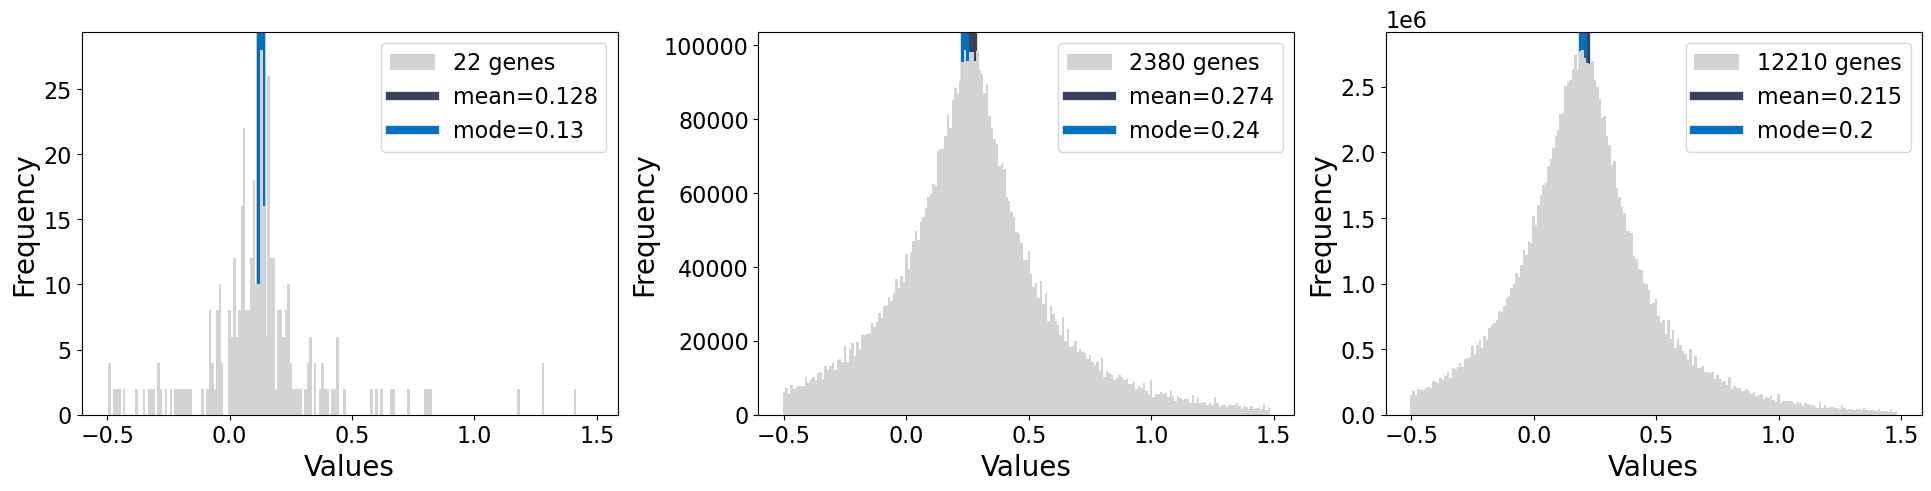

In [39]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),ax=axs[0],min_mean=0.1)
s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

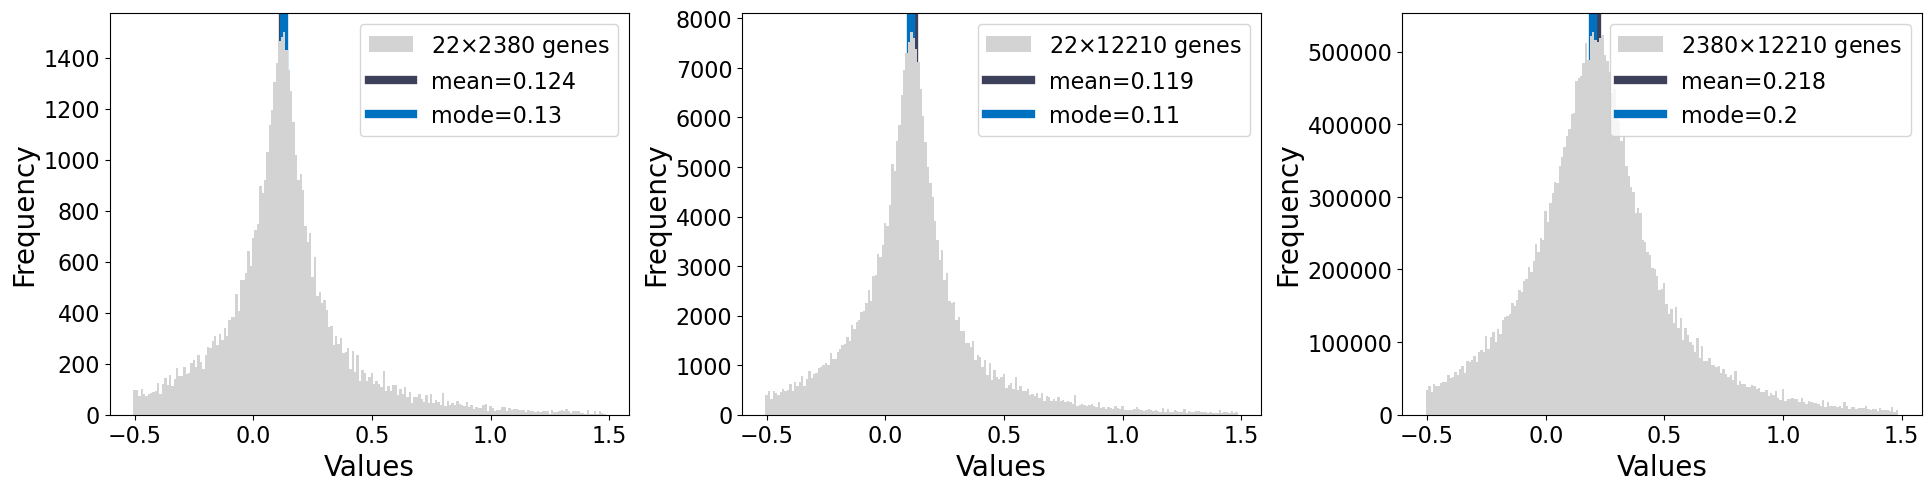

In [13]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s = estimate_s(N1=ERCC.X.toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

## Variance plot

In [54]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

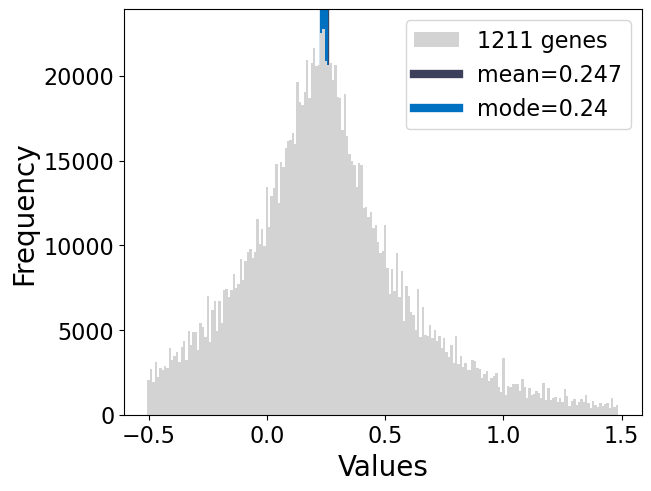

In [56]:
s = 0.24

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

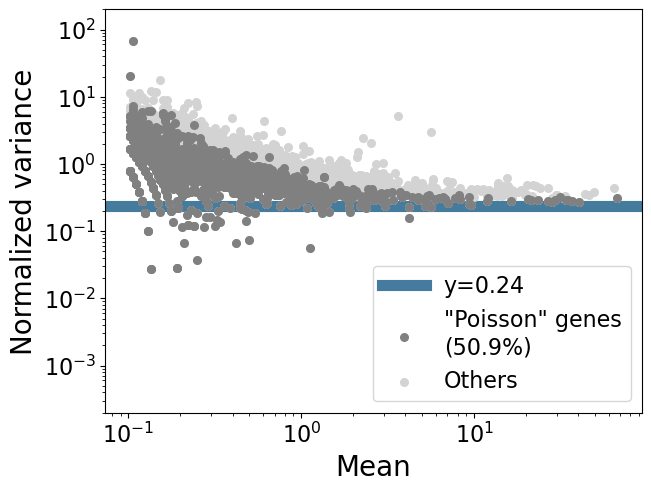

In [57]:
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

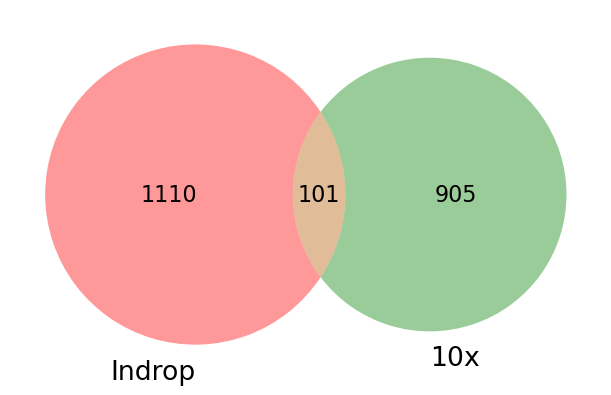

In [59]:
from matplotlib_venn import venn2

other_Pgenes = np.loadtxt("results/K562_10x_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(other_Pgenes)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, other_Pgenes_set], set_labels=('Indrop', '10x'))

# Show the plot
plt.show()

In [13]:
s = 0.13
X_ = ERCC.X.toarray()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
E_Pgene = ERCC.var_names[nonzero_idx][E_Pgene_mask]

ss = 0.27
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_ss = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

su = 0.21
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

100%|██████████| 1000/1000 [00:02<00:00, 440.42it/s]


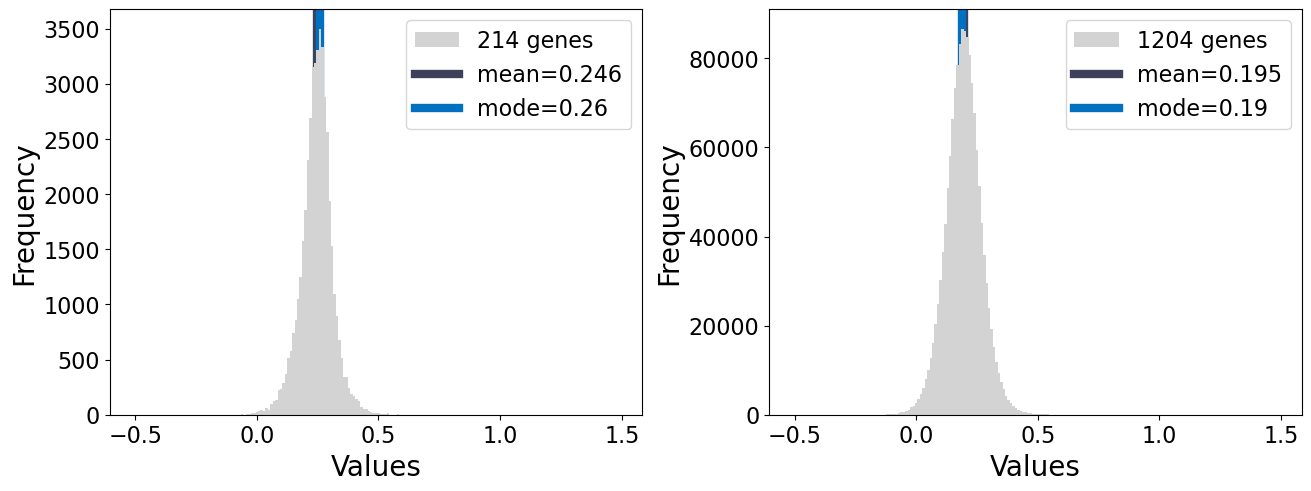

In [14]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0])

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [19]:
ss = 0.26
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_ss = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

su = 0.19
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

100%|██████████| 1000/1000 [00:02<00:00, 402.23it/s]


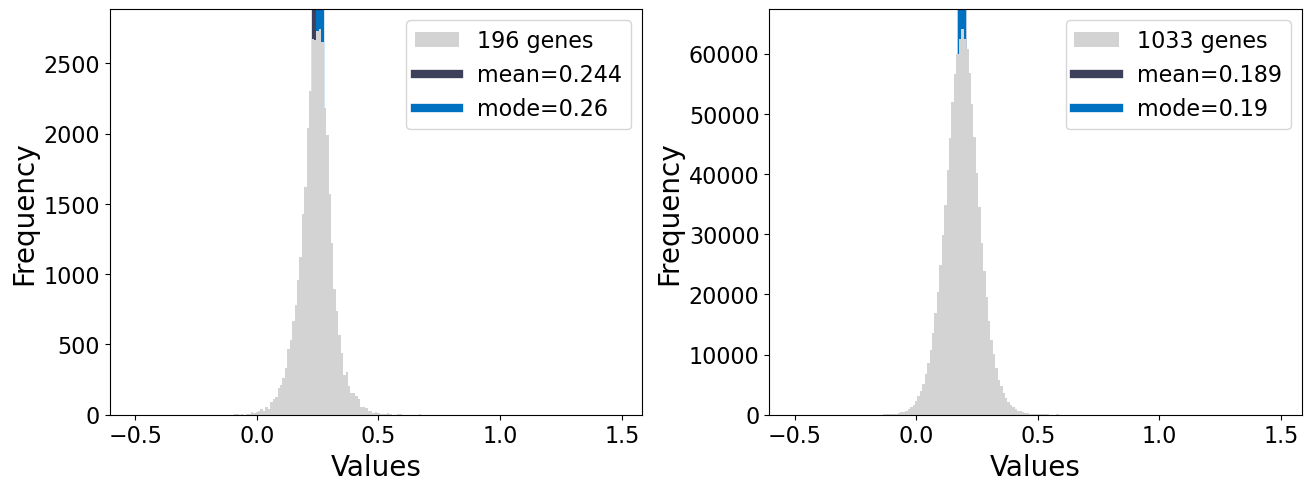

In [21]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0])

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1])

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

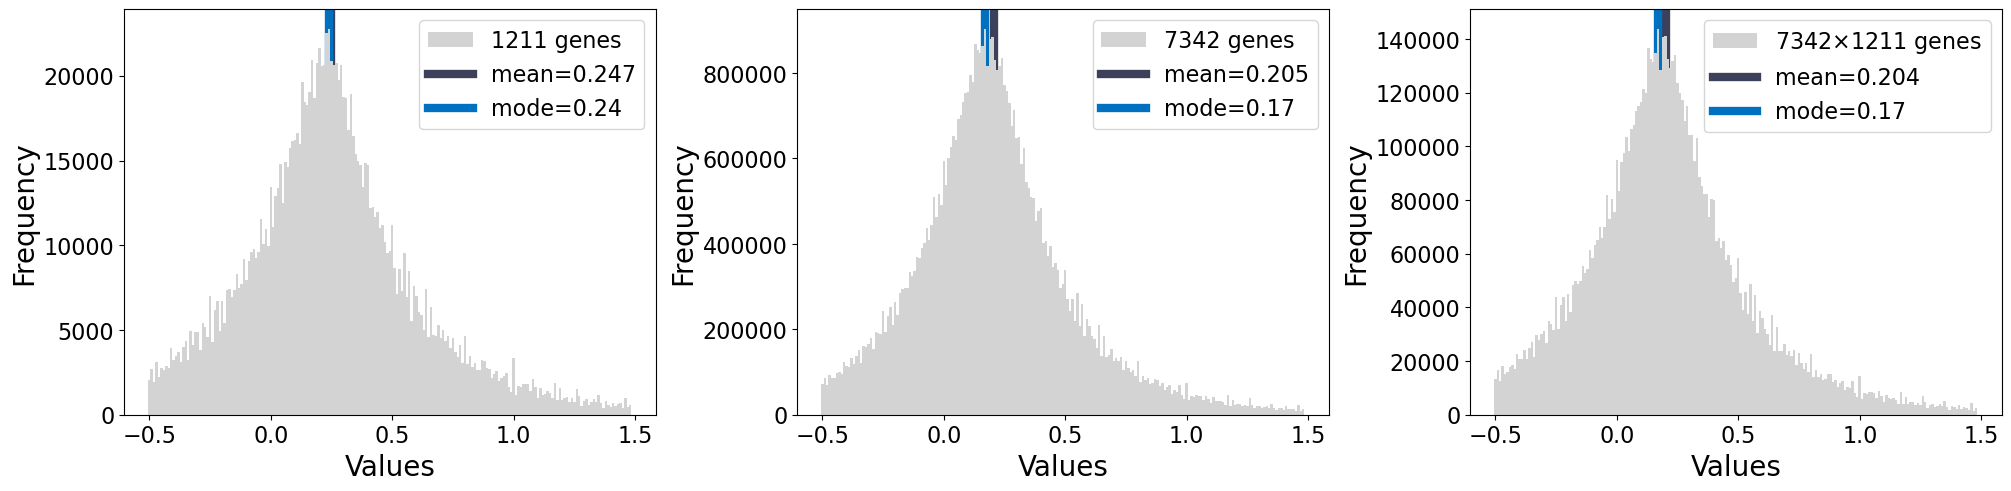

In [25]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=0.1)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=0.1)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=0.1)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

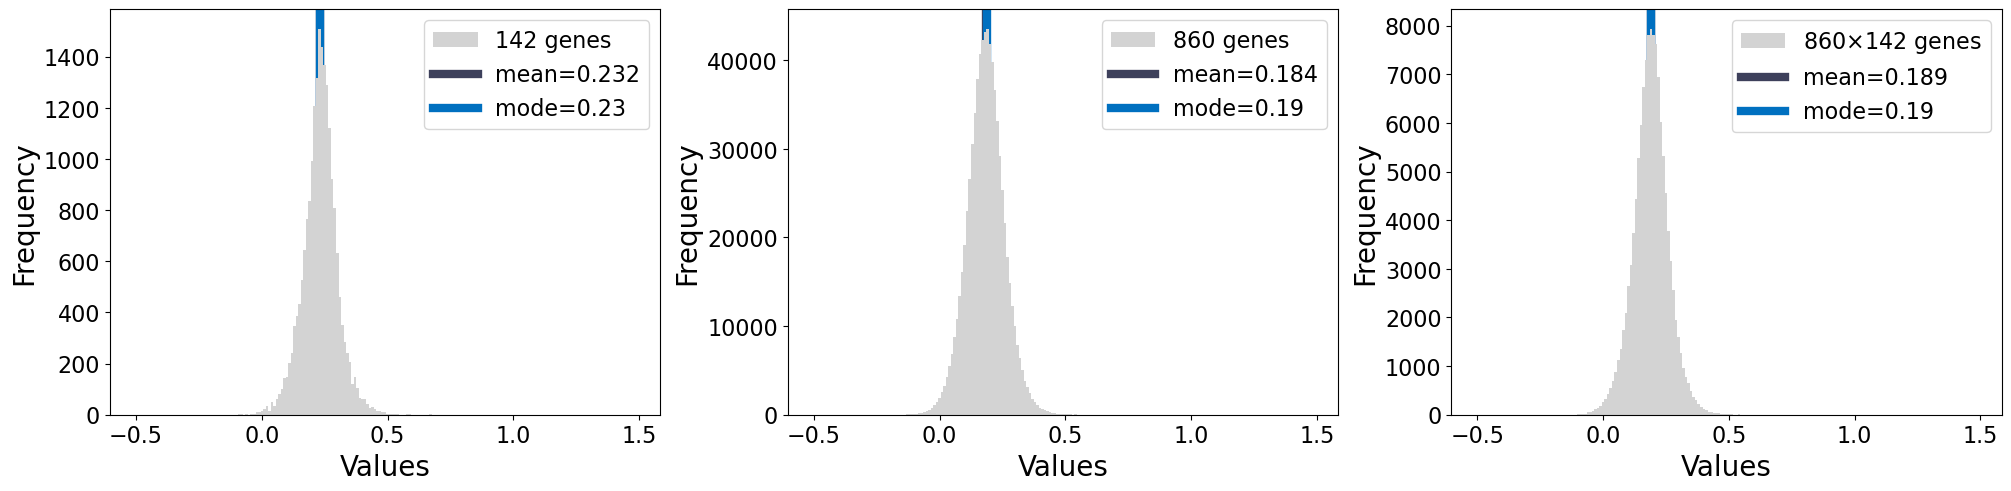

In [26]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=1)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=1)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=1)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [22]:
X = ERCC.X.toarray()
S = adata.layers["mature"].toarray()
U = adata.layers["nascent"].toarray()
A = adata.layers["ambiguous"].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
A_mean = np.mean(A,axis=0)
X_mean = np.mean(X,axis=0)

A_var = np.var(A,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

se = 0.13
su = 0.19
ss = 0.26

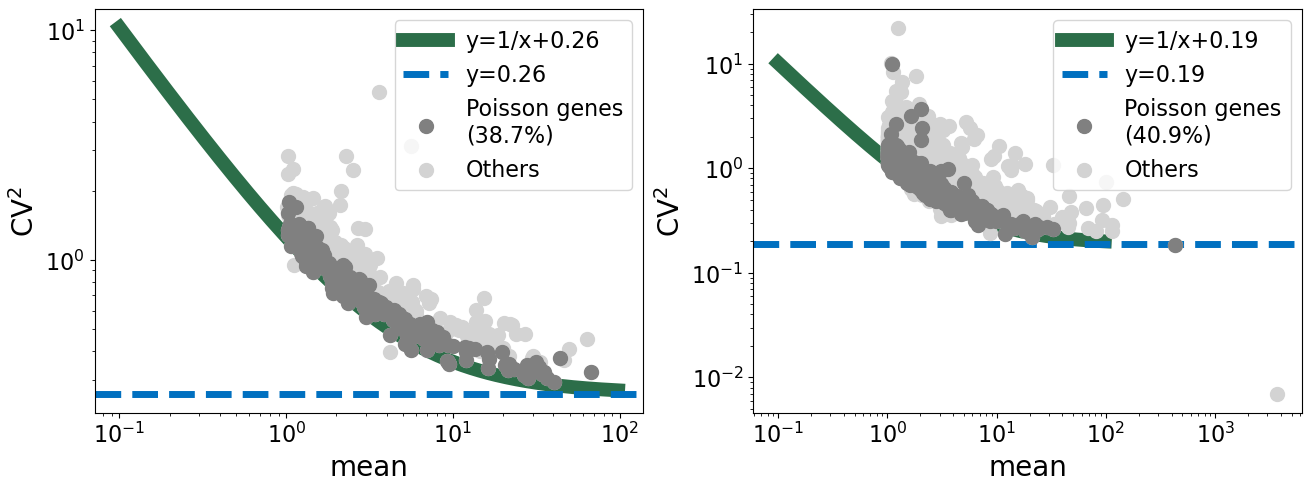

In [23]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))
x = 10**np.arange(-1,2,0.01)

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(S_Pgene)

ax[0].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[0].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(U_Pgene)

ax[1].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[1].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[1].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

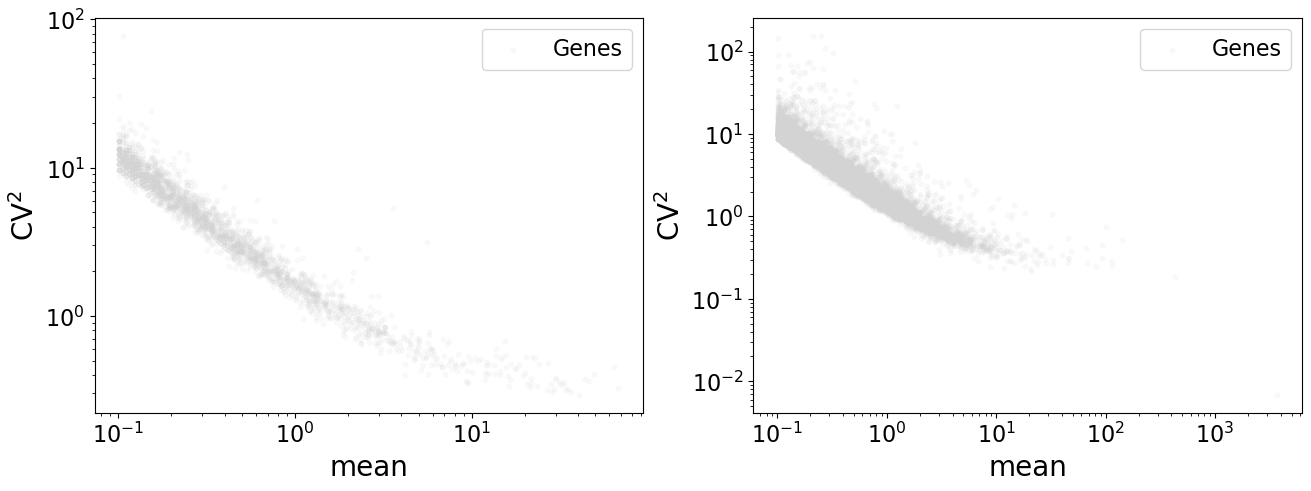

In [17]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=0.1, s=10, zorder=1, label='Genes')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=0.1, s=10, zorder=1, label='Genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

In [25]:
len(np.intersect1d(U_Pgene,S_Pgene)),len(S_Pgene),len(U_Pgene)

(410, 1211, 7342)

In [50]:
import gget

gget.enrichr(np.intersect1d(U_Pgenes,S_Pgenes),database='pathway',ensembl=True)

Thu Aug  1 07:39:35 2024 INFO Performing Enichr analysis using database KEGG_2021_Human. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Thu Aug  1 07:39:35 2024 INFO Getting gene symbols from Ensembl IDs.
Thu Aug  1 08:30:18 2024 INFO Performing Enichr analysis on the following gene symbols: DPM1, FIRRM, LAS1L, CDC27, UPF1, POLR2J, AP2B1, PRSS21, CSDE1, UFL1, RALBP1, MNAT1, RNH1, ERP44, SEC63, SARS1, ARID4A, RPL26L1, PSMA4, LSG1, OFD1, MRPS10, HEXB, MCUR1, AKR7A2, MRTO4, KMT2C, CCAR1, POLD1, HAGH, SP100, IARS2, ROCK1, VPS35, JMJD6, LMAN1, ACAT1, SLC25A3, ACTB, REXO2, MLH1, UBE2T, DYNC1I2, UBE2A, PPP2R5C, PCM1, RIF1, PTPRC, WDR70, SMAP2, AGBL5, MGST2, HBQ1, BAX, METTL2A, DYNLL1, SNX5, MAPKAPK5, RPLP0, FUS, BIRC5, RCOR1, NDUFB2, PDCD7, TOX4, LRRFIP2, AAAS, CBX5, MSH2, NANS, ACOT7, TECR, SMARCB1, ST13, RBX1, EP300, VTI1B, DHRS7, ERH, VRK1, PSMB5, ACIN1

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Ribosome,2.476871e-16,9.371346,336.753385,"[RPL10, RPLP0, MRPS10, MRPL14, RPL10A, RPL9, M...",5.622496e-14,KEGG_2021_Human
1,2,RNA transport,5.134570e-08,5.068497,85.073132,"[RANBP2, EIF4A1, UPF1, UBE2I, FUS, UPF3B, AAAS...",4.759648e-06,KEGG_2021_Human
2,3,Amyotrophic lateral sclerosis,8.019568e-08,3.604215,58.888542,"[COX7B, DCTN2, NDUFA12, COX4I1, NDUFB2, ATP5MC...",4.759648e-06,KEGG_2021_Human
3,4,Coronavirus disease,8.387045e-08,4.444195,72.413682,"[RPL41, RPL10, RPL23, RPLP0, RPL10A, RPL9, RPS...",4.759648e-06,KEGG_2021_Human
4,5,Huntington disease,5.880989e-07,3.632353,52.111084,"[COX7B, HDAC2, DCTN2, NDUFA5, NDUFA12, COX4I1,...",2.669969e-05,KEGG_2021_Human
...,...,...,...,...,...,...,...,...
222,223,Estrogen signaling pathway,9.574284e-01,0.315056,0.013706,[MAP2K2],9.743205e-01,KEGG_2021_Human
223,224,PI3K-Akt signaling pathway,9.614441e-01,0.487517,0.019169,"[MAP2K2, YWHAB, PPP2R5C, YWHAZ]",9.743205e-01,KEGG_2021_Human
224,225,Cell adhesion molecules,9.669904e-01,0.291316,0.009779,[PTPRC],9.755859e-01,KEGG_2021_Human
225,226,NOD-like receptor signaling pathway,9.846240e-01,0.237503,0.003680,[SUGT1],9.880840e-01,KEGG_2021_Human


In [46]:
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)
print(S_Pgene_mask.sum())

X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_U = X_[:,U_Pgene_mask].sum(1)
print(U_Pgene_mask.sum())

cellsize_X = adata.X.toarray().copy().sum(1)

NameError: name 'S_Pgene_mask' is not defined

(0.24246931, 0.19462174)

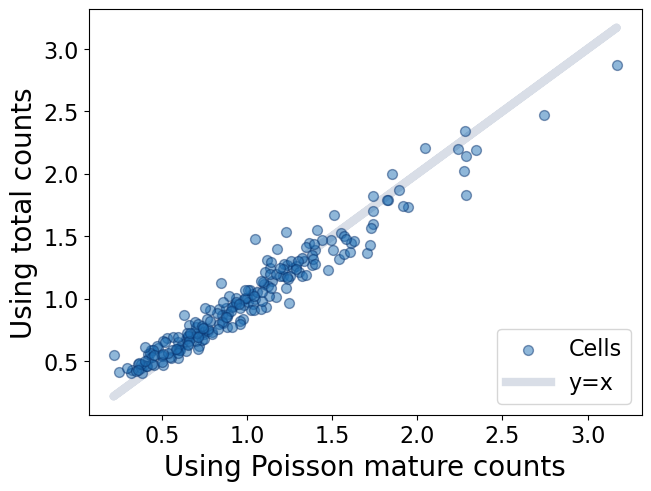

In [30]:
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)
cellsize_S = cellsize_S/cellsize_S.mean()
cellsize_X = adata.X.toarray().copy().sum(1)
cellsize_X = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(cellsize_S,cellsize_X,color='#2070b4',edgecolor='#08326e',s=50,alpha=0.5,label='Cells')
ax.plot(cellsize_S,cellsize_S,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using Poisson mature counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)
cellsize_S.var(),cellsize_X.var()

Text(0, 0.5, 'All counts')

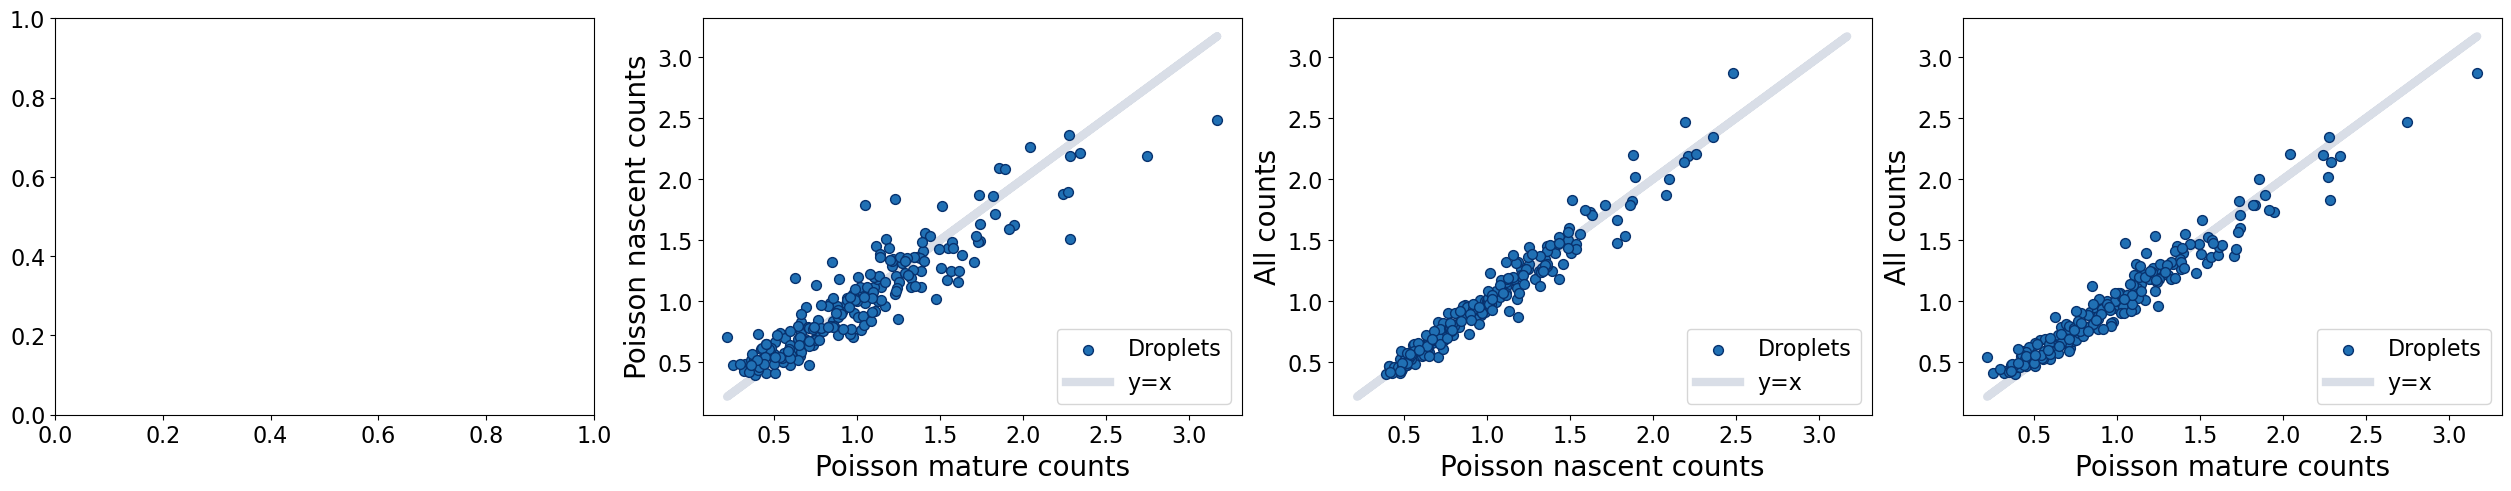

In [32]:
fig,ax = plt.subplots(1,4,figsize=(25,4.8))
ax[1].scatter(cellsize_S/cellsize_S.mean(),cellsize_U/cellsize_U.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[1].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[1].legend(loc='lower right',fontsize=16)
ax[1].set_xlabel('Poisson mature counts',fontsize=20)
ax[1].set_ylabel('Poisson nascent counts',fontsize=20)

ax[2].scatter(cellsize_U/cellsize_U.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[2].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[2].legend(loc='lower right',fontsize=16)
ax[2].set_xlabel('Poisson nascent counts',fontsize=20)
ax[2].set_ylabel('All counts',fontsize=20)

ax[3].scatter(cellsize_S/cellsize_S.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[3].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[3].legend(loc='lower right',fontsize=16)
ax[3].set_xlabel('Poisson mature counts',fontsize=20)
ax[3].set_ylabel('All counts',fontsize=20)

## Check covariance relationships

In [62]:
U_genes = adata.var_names[adata.layers["nascent"].toarray().mean(0) > 0.1][~U_Pgene_mask]
S_genes = adata.var_names[adata.layers["mature"].toarray().mean(0) > 0.1][~S_Pgene_mask]
cov_genes = np.append(U_genes,S_genes)
cov_genes = U_genes[U_genes.isin(S_genes)]
len(U_genes),len(S_genes),U_genes.isin(S_genes).sum()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


(4347, 1169, 413)

In [31]:
s_uu = 0.19
s_ss = 0.26
s_us = 0.19

idx = adata.var_names.isin(adata.var_names)

U = adata.layers["nascent"][:,idx].toarray()
S =  (adata.layers["mature"]+adata.layers["ambiguous"])[:,idx].toarray() 

idx = (U.mean(0)>1) & (S.mean(0)>1)
U = U[:,idx]
S = S[:,idx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2-s_uu
zeta_ss = (S_var-S_mean)/S_mean**2-s_ss

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean-s_us
zeta_us.shape

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


(653,)

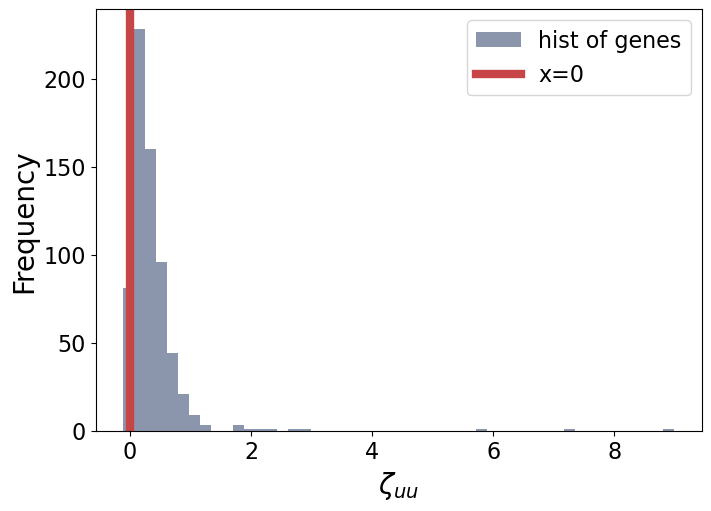

In [25]:
plt.figure(figsize=(7,5))
plt.hist(zeta_uu,bins=50,color=gray,label='hist of genes');
#plt.text(1.5, 300, str(np.around(100*(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0', color='k')
plt.axvline(x=0,c=red,label='x=0')
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.savefig(figprefix+"_uu.pdf", dpi=150)

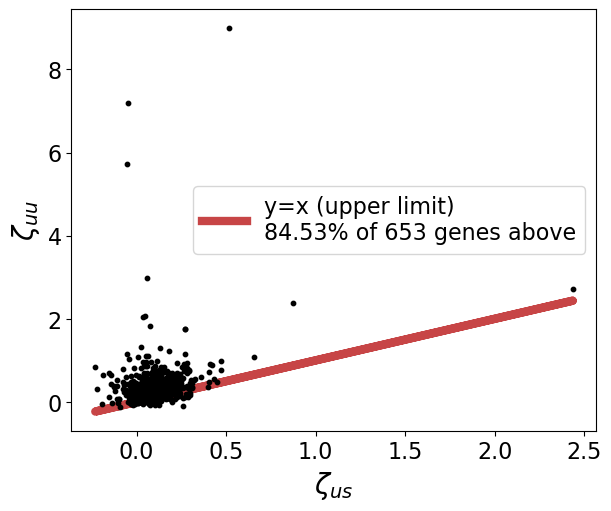

In [26]:
x=zeta_us
y=zeta_uu

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x (upper limit)\n' \
         +str(np.around(100*(x<y).mean(),2))+'% of '+str(len(zeta_uu))+' genes above')
#plt.text(0, 5, str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{uu}>\zeta_{us}$', color='k')
#plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,color=dark)
#plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label='1/mean')
plt.legend()
plt.xlabel(r'$\zeta_{us}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.savefig(figprefix+"_us.pdf", dpi=150)

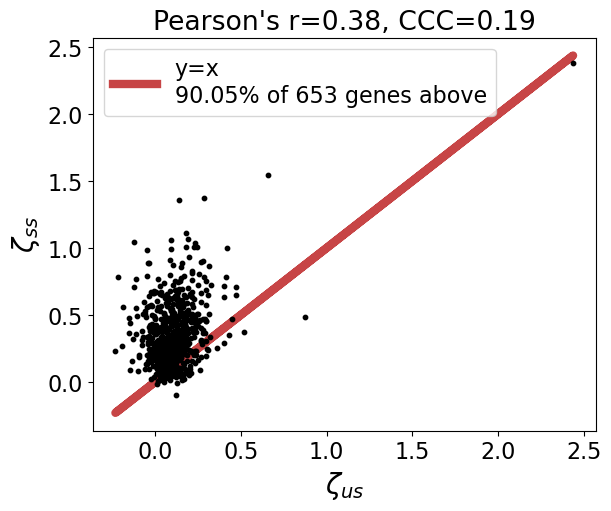

In [27]:
x=zeta_us
y=zeta_ss

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x\n' \
         +str(np.around(100*(x<y).mean(),2))+'% of '+str(len(zeta_uu))+' genes above')
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
#plt.text(-0.4, 2, "CCC = "+str(np.round(CCC(x,y),2)), fontsize=24, color='k')
plt.legend()
plt.xlabel(r'$\zeta_{us}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{ss}$',fontsize=label_font)
plt.savefig(figprefix+"_ss.pdf", dpi=150)

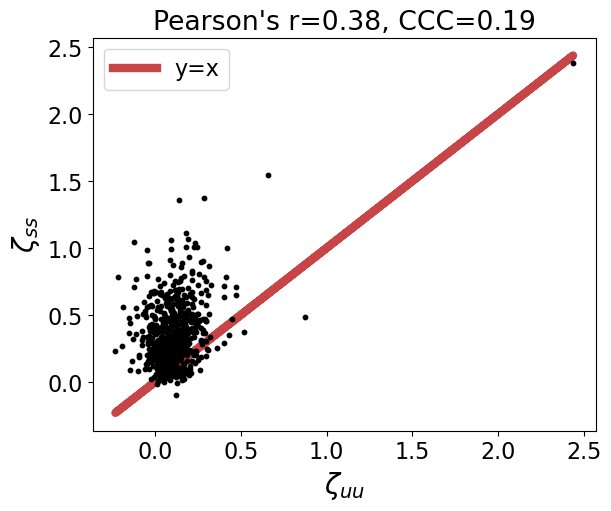

In [32]:
x=zeta_us
y=zeta_ss

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,label='y=x',c=red)
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
#plt.text(-0.4, 2, "CCC = "+str(np.round(CCC(x,y),2)), fontsize=24, color='k')
plt.legend()
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{ss}$',fontsize=label_font)
plt.savefig(figprefix+"_ss.pdf", dpi=150)